# BMTK vs BS/JAX: Grating LGN Simulation

对同一漂移光栅刺激，分别用 BMTK FilterNet 与 BS/JAX 后端进行 LGN 仿真，比较数值差异与运行时间。

提示：默认启用 x64 与自动回退（出现 NaN/Inf 或退化核时用 BMTK 路径兜底），确保结果稳定。

In [1]:
%env BRAINLGN_BACKEND=brainstate
%env BRAINLGN_JAX_X64=1
%env BRAINLGN_FALLBACK_BMTK_ON_NAN=1
%env BRAINLGN_ALIGN_START=lmax

import os, sys, time, numpy as np, matplotlib.pyplot as plt
PKG_ROOT = os.path.abspath(os.path.join('..'))
if PKG_ROOT not in sys.path: sys.path.insert(0, PKG_ROOT)

try:
    import jax; HAVE_JAX=True
    try: jax.config.update('jax_enable_x64', True)
    except Exception: pass
except Exception:
    HAVE_JAX=False
print('HAVE_JAX =', HAVE_JAX)
%matplotlib inline

env: BRAINLGN_BACKEND=brainstate
env: BRAINLGN_JAX_X64=1
env: BRAINLGN_FALLBACK_BMTK_ON_NAN=1
env: BRAINLGN_ALIGN_START=lmax
HAVE_JAX = True


## 1) Stimulus (drifting grating) 与群体参数

In [2]:
# 可按需调小/调大，注意 BMTK 逐元评估在大 N 时较慢
row, col = 120, 240
frame_rate = 1000.0
duration = 0.5
gray = 0.2

layout = { 'X_grids': 4, 'Y_grids': 3, 'X_len': 240.0, 'Y_len': 120.0 }  # 小规模便于完整对比
cell_types = [
  { 'name': 'sON',  'n_per_tile': 1, 'spatial': {'sigma_range':[2.0,3.0]}, 'temporal': {'weights':[0.6,-0.4], 'kpeaks':[15.0,45.0], 'delays':[0,0], 'jitter_percent':0.05}, 'amplitude_range':[1.5,2.0],  'transfer': {'bias_range':[0.8,1.2]} },
  { 'name': 'sOFF', 'n_per_tile': 1, 'spatial': {'sigma_range':[2.0,3.0]}, 'temporal': {'weights':[0.5,-0.3], 'kpeaks':[20.0,60.0], 'delays':[0,0], 'jitter_percent':0.05}, 'amplitude_range':[-2.0,-1.5], 'transfer': {'bias_range':[0.5,1.0]} }
]
subset_ref = None  # 若设为整数，则 BMTK 只算子集并与 BS 子集对比
base_seed = 123
print('Params ready.')

Params ready.


## 2) 构造刺激与群体

Stimulus: (700, 120, 240) frame_rate: 1000.0
Population N = 24


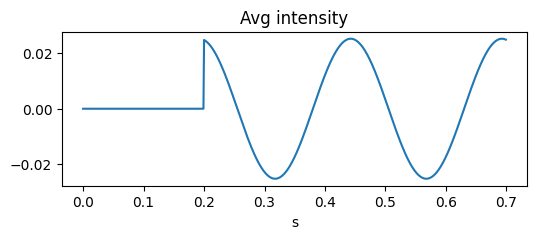

In [3]:
from brainlgn_x.stimuli import drifting_grating
from brainlgn_x.generator import generate_population
from bmtk.simulator.filternet.lgnmodel.movie import Movie as BMovie

movie = drifting_grating(row, col, frame_rate, duration, gray_screen=gray, cpd=0.04, temporal_f=4.0, theta=0.0, contrast=0.8)
stim = movie.as_array()
lfs, trs, meta = generate_population(cell_types, layout, base_seed=base_seed)
N = len(lfs)
print('Stimulus:', stim.shape, 'frame_rate:', movie.frame_rate)
print('Population N =', N)
plt.figure(figsize=(6,2)); plt.plot(movie.t_range, stim.mean(axis=(1,2))); plt.title('Avg intensity'); plt.xlabel('s'); plt.show()

## 3) BS/JAX 多元评估（计时）

c:\Users\76629\anaconda3\envs\brainlgn\Lib\site-packages\bmtk\simulator\filternet\lgnmodel\kernel.py:132: RuntimeWarning: invalid value encountered in divide
  self.kernel /= np.abs(self.kernel.sum())


BS/JAX time(s)= 0.4646651000366546 rates shape= (24, 700)
NaN in rates_bs: 0


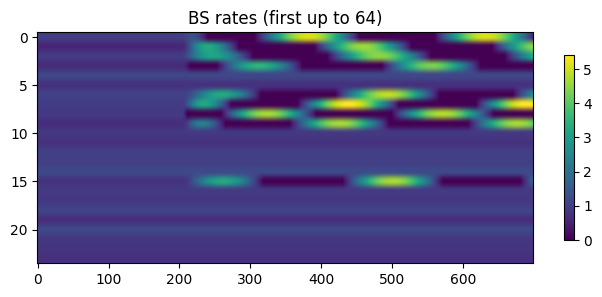

In [4]:
from brainlgn_x.bs_backend import eval_separable_multi
t0 = time.perf_counter()
rates_bs = eval_separable_multi(lfs, trs, stim, frame_rate=movie.frame_rate, downsample=1)
t1 = time.perf_counter()
bs_time = t1 - t0
print('BS/JAX time(s)=', bs_time, 'rates shape=', rates_bs.shape)
print('NaN in rates_bs:', np.isnan(rates_bs).sum())
plt.figure(figsize=(8,3)); plt.imshow(rates_bs[:min(64,N)], aspect='auto', cmap='viridis'); plt.title('BS rates (first up to 64)'); plt.colorbar(shrink=0.8); plt.show()

## 4) BMTK 参考评估（计时）

BMTK time(s)= 0.10965989995747805 ref shape= (24, 700)


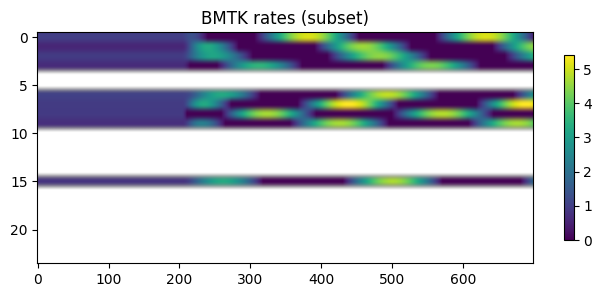

In [5]:
from bmtk.simulator.filternet.lgnmodel.lnunit import LNUnit
mv = BMovie(stim, frame_rate=movie.frame_rate)
idxs = list(range(N)) if subset_ref is None else list(range(min(int(subset_ref), N)))
t0 = time.perf_counter()
ref = []
for i in idxs:
    ln = LNUnit(lfs[i], trs[i])
    _, y = ln.get_cursor(mv, separable=True).evaluate()
    ref.append(np.asarray(y))
rates_ref = np.stack(ref, axis=0)
t1 = time.perf_counter()
bmtk_time = t1 - t0
print('BMTK time(s)=', bmtk_time, 'ref shape=', rates_ref.shape)
plt.figure(figsize=(8,3)); plt.imshow(rates_ref[:min(64,len(idxs))], aspect='auto', cmap='viridis'); plt.title('BMTK rates (subset)'); plt.colorbar(shrink=0.8); plt.show()

## 5) 数值对齐与速度对比

Parity (K=24) -> MAE=nan, MaxAbs=nan
Timing: BS=0.465s, BMTK=0.110s, speedup=0.24x


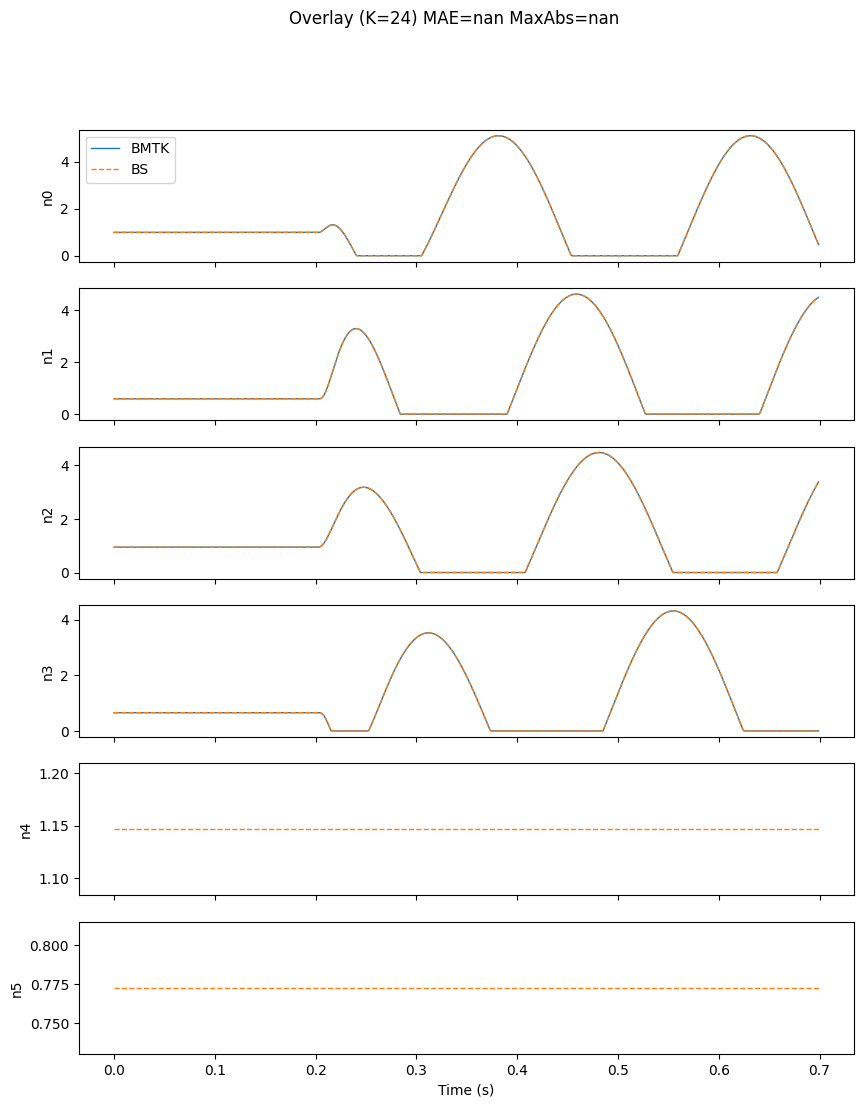

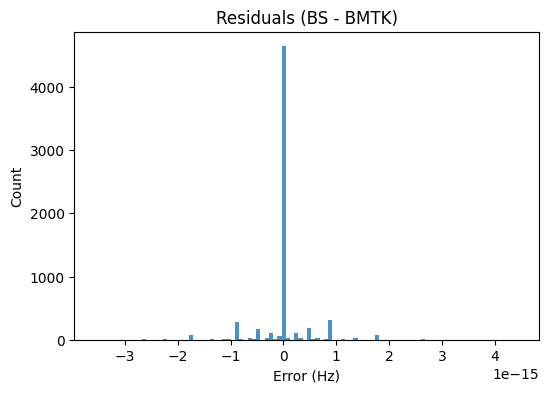

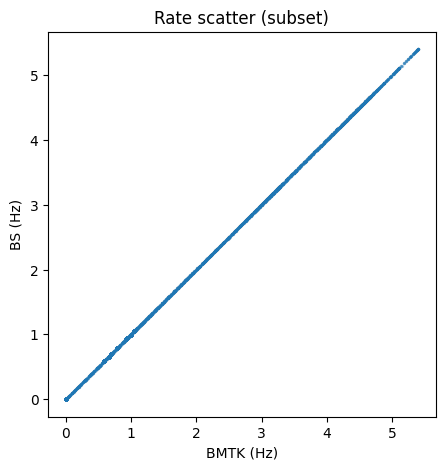

In [6]:
K = rates_ref.shape[0]
mae = float(np.mean(np.abs(rates_bs[:K] - rates_ref)))
mx  = float(np.max(np.abs(rates_bs[:K] - rates_ref)))
print(f'Parity (K={K}) -> MAE={mae:.3e}, MaxAbs={mx:.3e}')
print(f'Timing: BS={bs_time:.3f}s, BMTK={bmtk_time:.3f}s, speedup={bmtk_time/max(bs_time,1e-12):.2f}x')

# Overlay a few traces
n_show = min(6, K); T = rates_ref.shape[1]; t = np.arange(T)/movie.frame_rate
fig, axes = plt.subplots(n_show, 1, figsize=(10, 2*n_show), sharex=True)
if n_show == 1: axes=[axes]
for i in range(n_show):
    axes[i].plot(t, rates_ref[i], label='BMTK', lw=1)
    axes[i].plot(t, rates_bs[i], '--', label='BS', lw=1)
    axes[i].set_ylabel(f'n{i}')
    if i==0: axes[i].legend()
axes[-1].set_xlabel('Time (s)'); fig.suptitle(f'Overlay (K={K}) MAE={mae:.2e} MaxAbs={mx:.2e}'); plt.show()

# Residual histogram & scatter
resid = (rates_bs[:K] - rates_ref).ravel()
plt.figure(figsize=(6,4)); plt.hist(resid, bins=100, alpha=0.8); plt.title('Residuals (BS - BMTK)'); plt.xlabel('Error (Hz)'); plt.ylabel('Count'); plt.show()
plt.figure(figsize=(5,5)); plt.scatter(rates_ref.ravel(), rates_bs[:K].ravel(), s=2, alpha=0.3)
lim = max(rates_ref.max(), rates_bs[:K].max())
plt.plot([0, lim], [0, lim], 'k--', lw=1); plt.xlabel('BMTK (Hz)'); plt.ylabel('BS (Hz)'); plt.title('Rate scatter (subset)'); plt.show()